The purpose of this notebook is to post-process a .psv.gz simulation file to add schools and FEMA regions. This does not represent how an operational version would run... it's simply to add these new features to show off on the example page of the v2 dashboard. 

In [1]:
import json
from io import StringIO
import gzip

from pygridder import pygridder as pgrid

In [2]:
import pathlib
import glob
import os

import argparse
import geojson
import pandas as pd
import json
import random
import numpy as np
import pyproj

from datetime import datetime, timedelta

In [3]:
# Read in example psv
file = '../scripts/impacts-data/output/20110427162927.psv.gz'
df = pd.read_csv(file, sep="|")

In [4]:
df.head()

,sim,population,distance,rating,states,counties,wfos,hospitals,hospitalbeds,mobileparks,mobilehomes,psubstations,plines,slon,slat,elon,elat
0,1,2544,4.4415,3,MS,28081,MEG,0,0,0,0,0,0,-88.6066,34.3619,-88.5379,34.3921
1,1,624,3.9692,2,KY,"21051,21121",JKL,0,0,0,0,0,0,-83.8111,37.0729,-83.7601,37.1134
2,1,3280,27.0073,4,"AL,GA","1019,13055,13115","BMX,FFC",0,0,0,0,3,3,-85.5258,34.2540,-85.1459,34.4873
3,1,928,1.1927,0,AL,1089,HUN,0,0,0,0,0,0,-86.4543,35.0071,-86.4403,35.0201
4,1,6464,0.1907,0,PA,42049,CLE,0,0,0,0,0,0,-79.9165,42.1845,-79.9137,42.1863


### Get projection information to properly grid lat/lon lines and get school #'s

In [5]:
ndfd_file = '../../dev/impacts-app/scripts/impacts-data/orig-gis-data/ndfd.npz'

In [10]:
impacts_file = './assets/impact-grids-new.npz'

In [11]:
with np.load(ndfd_file) as NPZ:
    X = NPZ['X']
    Y = NPZ['Y']
    proj = pyproj.Proj(NPZ['srs'].item())

In [12]:
G = pgrid.Gridder(X,Y)

In [13]:
with np.load(impacts_file) as NPZ:
    schools = NPZ['schools']

- iterate through df rows
- for each row...
    - project lons/lats into ndfd points
    - grid lines using these ndfd start/end points
    - use returned indices to grab and sum school counts for the tornado
    - set that value to a new column 'schools'

Example run through

In [15]:
tor = df.iloc[0,:]

In [17]:
x1s, y1s = proj(tor['slon'],tor['slat'])
x2s, y2s = proj(tor['elon'],tor['elat'])

In [18]:
idxs = G.grid_lines(x1s,y1s,x2s,y2s)

In [43]:
f'Schools "Exposed": {schools[idxs[0]].sum()}'

'Schools "Exposed": 4'

### Processing all tors and getting school counts

In [14]:
school_total = []

for row in np.arange(df.shape[0]):
    
    tor = df.iloc[row,:]
    
    x1s, y1s = proj(tor['slon'],tor['slat'])
    x2s, y2s = proj(tor['elon'],tor['elat'])
    
    idxs = G.grid_lines(x1s,y1s,x2s,y2s)
    
    school_count = schools[idxs[0]].sum()
    school_total.append(school_count)

In [15]:
df['schools'] = school_total

In [69]:
psv_str = df.to_csv(sep='|',index=False)

with gzip.GzipFile('../data/output/examples/20210428124600_schools.psv.gz','w') as OUT:
    OUT.write(psv_str.encode())

Making sure the file is OK

In [70]:
# Read in example psv
file = '../data/output/examples/20210428124600_schools.psv.gz'
df_new = pd.read_csv(file, sep="|")

### Add FEMA Column

In [16]:
fema_dict = {
    'WA': '10',
    'OR': '10',
    'ID': '10',
    'CA': '9', 
    'NV': '9',
    'AZ': '9',
    'MT': '8',
    'WY': '8',
    'UT': '8',
    'CO': '8',
    'ND': '8',
    'SD': '8',
    'NE': '7',
    'KS': '7',
    'IA': '7',
    'MO': '7',
    'NM': '6',
    'TX': '6',
    'OK': '6',
    'AR': '6',
    'LA': '6',
    'MN': '5',
    'WI': '5',
    'MI': '5',
    'IL': '5',
    'IN': '5',
    'OH': '5',
    'KY': '4',
    'TN': '4',
    'MS': '4',
    'AL': '4',
    'GA': '4',
    'FL': '4',
    'SC': '4',
    'NC': '4',
    'VA': '3',
    'WV': '3',
    'PA': '3',
    'DC': '3',
    'MD': '3',
    'DE': '3',
    'NY': '2',
    'NJ': '2',
    'CT': '1',
    'RI': '1',
    'MA': '1',
    'VT': '1',
    'NH': '1',
    'ME': '1'
}

In [17]:
fema = []

for row in np.arange(df.shape[0]):
    
    tor = df.iloc[row,:]
    
    # Offshore tornadoes have 'nan' for the state
    try:
        states = tor['states'].split(',')
    except AttributeError:
        fema.append(np.nan)
        continue
    
    if len(states) > 1:
        
        fema_list = list(map(lambda state: fema_dict[state], states))
        fema_str = ','.join(fema_list)
        fema.append(fema_str)
        
    else:
        fema.append(fema_dict[tor['states']])

In [18]:
df['fema'] = fema

In [19]:
psv_str = df.to_csv(sep='|',index=False)

with gzip.GzipFile('../data/output/examples/20110427162927_schools_fema.psv.gz','w') as OUT:
    OUT.write(psv_str.encode())

### Add hours to tornadoes

In [3]:
file = '../data/output/examples/20110427/psvs/20110427162927_schools_fema.psv.gz'
df = pd.read_csv(file, sep="|")

Get time distribution from actual event

In [5]:
tors = pd.read_csv('../../../gen-assets/1950-2019_tors_CONUS.csv')

In [13]:
filtered_tors = tors[(tors['date'] == '2011-04-27') | (tors['date'] == '2011-04-28')]

In [26]:
def timeFormat(x):
    
    x = int(x) + 6
    
    if x > 23:
        x = x - 24
        
    return x

In [30]:
filtered_tors['hour'] = filtered_tors['time'].apply(lambda x: timeFormat(x[:2]))

<ipython-input-30-44c705883842>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_tors['hour'] = filtered_tors['time'].apply(lambda x: timeFormat(x[:2]))


In [61]:
fema4_times = filtered_tors[filtered_tors['st'].isin(['MS','AL','GA','FL','SC','NC','TN','KY'])]['hour']
nat_times = filtered_tors['hour']

<AxesSubplot:>

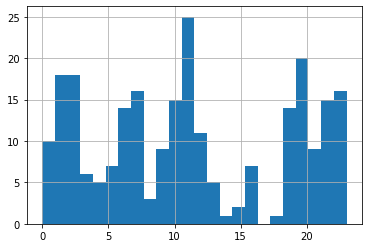

In [83]:
nat_times.hist(bins=24)

In [88]:
import random

In [94]:
random_hours = []

for row in np.arange(df.shape[0]):
    
    tor = df.iloc[row,:]
    
    if tor['fema'] == '4':
        hour = fema4_man_times.sample(n=1).values[0] + random.randint(-1,1)
        if hour < 0:
            hour = 24 + hour
        elif hour > 23:
            hour = hour - 24
        
        random_hours.append(hour)
    else:
        hour = fema4_man_times.sample(n=1).values[0] + random.randint(-1,1)
        if hour < 0:
            hour = 24 + hour
        elif hour > 23:
            hour = hour - 24
            
        random_hours.append(hour)

In [95]:
df['time'] = random_hours

In [96]:
df.head()

,sim,population,distance,rating,states,counties,wfos,hospitals,hospitalbeds,mobileparks,mobilehomes,psubstations,plines,slon,slat,elon,elat,schools,fema,time
0,1,2544,4.4415,3,MS,28081,MEG,0,0,0,0,0,0,-88.6066,34.3619,-88.5379,34.3921,0,4,20
1,1,624,3.9692,2,KY,"21051,21121",JKL,0,0,0,0,0,0,-83.8111,37.0729,-83.7601,37.1134,2,4,13
2,1,3280,27.0073,4,"AL,GA","1019,13055,13115","BMX,FFC",0,0,0,0,3,3,-85.5258,34.2540,-85.1459,34.4873,1,"4,4",2
3,1,928,1.1927,0,AL,1089,HUN,0,0,0,0,0,0,-86.4543,35.0071,-86.4403,35.0201,0,4,18
4,1,6464,0.1907,0,PA,42049,CLE,0,0,0,0,0,0,-79.9165,42.1845,-79.9137,42.1863,0,3,16


In [97]:
psv_str = df.to_csv(sep='|',index=False)

with gzip.GzipFile('../data/output/examples/20110427/psvs/20110427162927_schools_fema_time.psv.gz','w') as OUT:
    OUT.write(psv_str.encode())

10